# Import libraries

In [188]:
from time import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from numpy.random import normal, rand, seed
from warnings import catch_warnings, simplefilter
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
import os


# Load Human Activity Recognition Using Smartphones

In [189]:
# Load the data
# Set the path to the UCI HAR Dataset folder
data_folder = "/Users/davepipon/Documents/AI221_A9/UCI HAR Dataset"

# Load training data
X_train = np.loadtxt(os.path.join(data_folder, "train", "X_train.txt"))
y_train = np.loadtxt(os.path.join(data_folder, "train", "y_train.txt"), dtype=int)

# Load test data
X_test = np.loadtxt(os.path.join(data_folder, "test", "X_test.txt"))
y_test = np.loadtxt(os.path.join(data_folder, "test", "y_test.txt"), dtype=int)

# Check data

In [190]:

# Display basic information about the dataset
print("Basic Information:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Check for missing values
print("\nMissing Values:")
print("X_train missing values:", np.isnan(X_train).sum())
print("X_test missing values:", np.isnan(X_test).sum())
print("y_train missing values:", np.isnan(y_train).sum())
print("y_test missing values:", np.isnan(y_test).sum())

Basic Information:
X_train shape: (7352, 561)
X_test shape: (2947, 561)
y_train shape: (7352,)
y_test shape: (2947,)

Missing Values:
X_train missing values: 0
X_test missing values: 0
y_train missing values: 0
y_test missing values: 0


# Bayesian optimization

## Data manipulation

### Preprocessing

In [191]:
# Scale features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert labels to one-hot encoding
he = OneHotEncoder()
y_train_cat = he.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_cat = he.transform(y_test.reshape(-1, 1)).toarray()

print("\nOne-hot encoding:")
print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)



One-hot encoding:
y_train_cat shape: (7352, 6)
y_test_cat shape: (2947, 6)


### Stratified split data for training and validation

In [192]:
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_scaled, y_train_cat,
    test_size=0.3,
    stratify=y_train,
    random_state=42
)

print("\nTraining Set:")
print("X_train_part shape:", X_train_part.shape)
print("y_train_part shape:", y_train_part.shape)

print("\nValidation Set:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


Training Set:
X_train_part shape: (5146, 561)
y_train_part shape: (5146, 6)

Validation Set:
X_val shape: (2206, 561)
y_val shape: (2206, 6)


## Develop optimization algorithm

### Define surrogate function and neural network

In [193]:
# Define the surrogate function
model = GaussianProcessRegressor(kernel=RBF(length_scale=0.01), 
                                 normalize_y=False, 
                                 n_restarts_optimizer=10,
                                 alpha=0.02**2,
                                 random_state=0)

seed(5)
# catch any warning generated when making a prediction
with catch_warnings():
    # ignore generated warnings
    simplefilter("ignore")

def plot_surrogate_acquisition(model, feat_fine, X, y, make_plot):
    # model:  contains the fitted GPR
    # feat_fine: contains finely separated points
    # X:      contains the X samples from the objective func.
    # y:      contains the objective function values at X
    
    y_fine_pred, y_fine_std = model.predict(feat_fine, return_std=True)
    y_pred, y_std = model.predict(feat_fine, return_std=True)

    xi = 0.02   # Degree of exploration
    
    best = max(y_fine_pred)
    probs = norm.cdf((y_fine_pred - best - xi) / (y_fine_std+1E-9))
    next_X = feat_fine[np.argmax(probs,0)]
    
    if make_plot == 1:
        # Plot the surrogate model and the samples
        plt.figure(figsize=(7,7))
        plt.subplot(2,1,1)
        plt.scatter(X, y, 20, 'b', label='Sampled points')
        plt.plot(feat_fine, y_fine_pred, 'b', lw=0.8, label='GP mean')
        plt.fill_between(
            feat_fine.ravel(),
            y_fine_pred - y_fine_std,
            y_fine_pred + y_fine_std,
            color='b',
            alpha=0.1,
            label='GP 1-std.dev.'
        )
        plt.grid()
        plt.title(f"After {len(y)} samples")
        plt.legend(loc='upper left')
    
        # Plot the acquisition function: Probability of Improvement
        plt.subplot(2,1,2)
        plt.plot(feat_fine, probs, 'm', lw=2)
        plt.ylabel('Probability of Improvement')
        plt.scatter(next_X,max(probs),25,'m',edgecolor='k')
        plt.grid()
    
    return next_X

# Build objective neural network for training
def fcnn(n_units1, learning_rate,n_batch,n_patience,epoch_input,X_train,y_train,X_val,y_val):
    input_dim = X_train.shape[1]

    # Define hyperparameters to optimize
    n_units1 = int(round(n_units1))
    n_units2 = int(round(n_units1/2))

    # Build fully-connected neural network
    nn_trial = Sequential([ Input(shape=(input_dim,)),
    Dense(n_units1, activation='relu'),
    Dense(n_units2, activation='relu'),
    Dense(6, activation='softmax')])

    # Early stopping to prevent overtraining
    early_trial = EarlyStopping(monitor='val_loss', patience=n_patience, restore_best_weights=True)

    # Compile the model
    nn_trial.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Train the neural network
    history_nn_trial = nn_trial.fit(X_train, y_train, epochs=epoch_input, batch_size=n_batch, callbacks=[early_trial],
                            validation_data=(X_val, y_val), verbose=0)

    # Report validation loss for hyperparameter tuning
    val_acc = history_nn_trial.history['val_accuracy'][-1]
    
    return val_acc*100

## Implement optimization algorithm

### Initialize hyperparameter values

In [194]:
# Initialize the surrogate model
feat_min = 50
feat_max = 300
feat_fine = np.linspace(feat_min, feat_max, 250).reshape(-1, 1)
initial_samples = 5
feat_init = (rand(initial_samples) * (feat_max - feat_min) + feat_min).astype(int)

# Generate initial samples
feat = []
y_feat = []
for i in range(initial_samples):
    feat.append(feat_init[i])
    y_feat.append(fcnn(feat_init[i], 0.001, 50, 10, 10, X_train_part, y_train_part, X_val, y_val))
feat = np.array(feat).reshape(-1, 1)
y_feat = np.array(y_feat).reshape(-1, 1)
print("Initial samples:")
print("feat:", feat)
print("y_feat:", y_feat)

Initial samples:
feat: [[105]
 [267]
 [101]
 [279]
 [172]]
y_feat: [[96.96282744]
 [98.09610248]
 [97.6881206 ]
 [97.59746194]
 [98.09610248]]


### Search for optimized hyperparameter

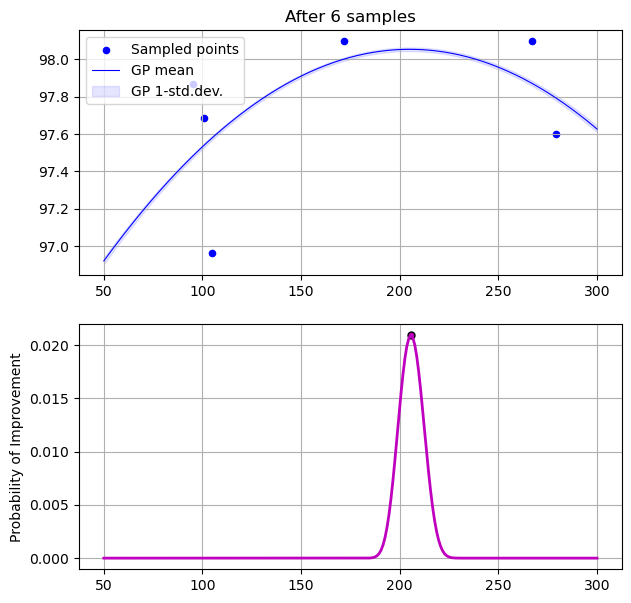

Sample 7: 206


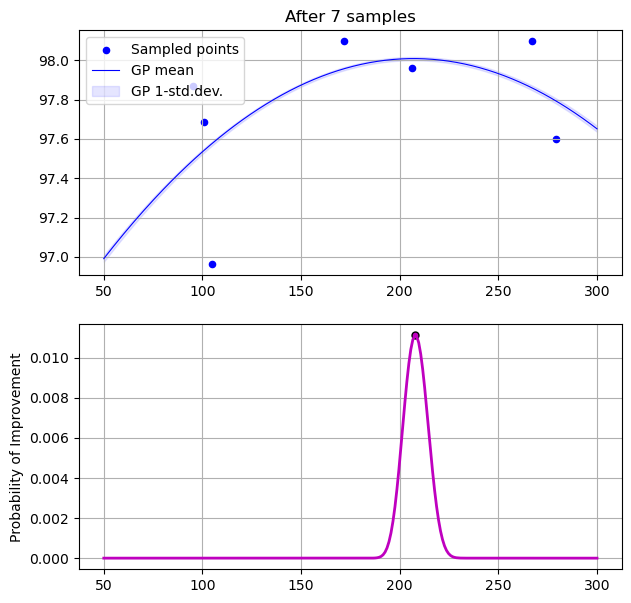

Sample 8: 208


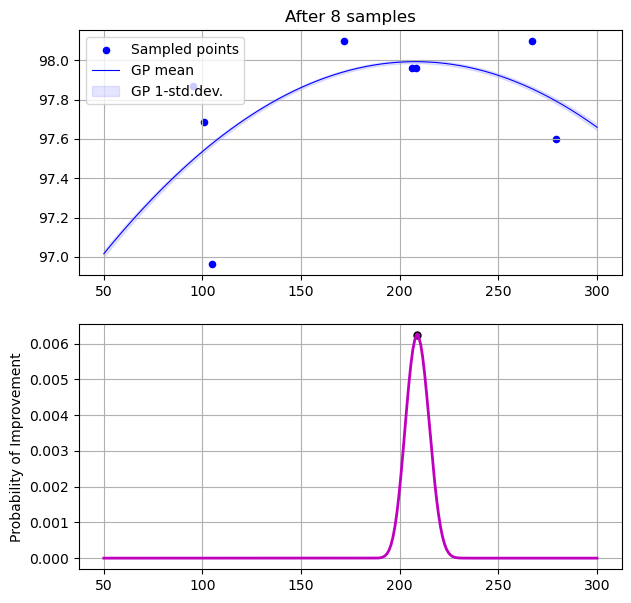

Sample 9: 209


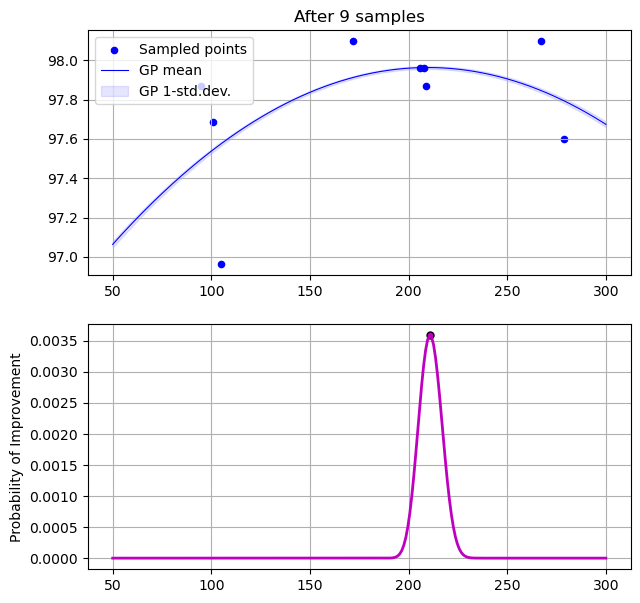

Sample 10: 211


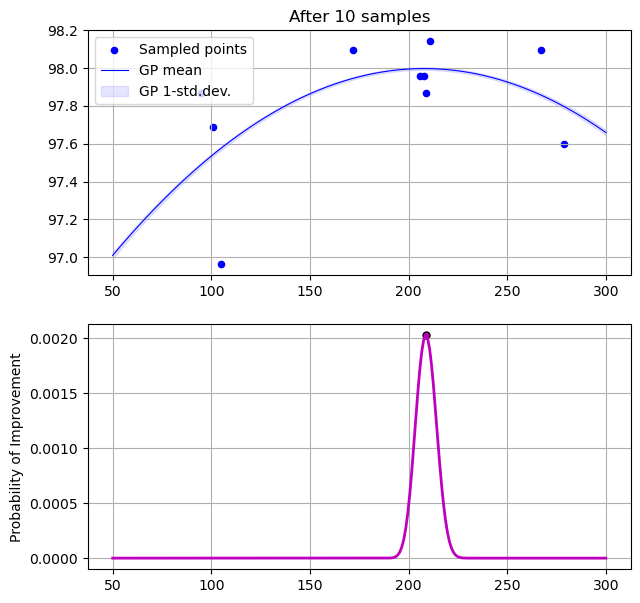

Sample 11: 209


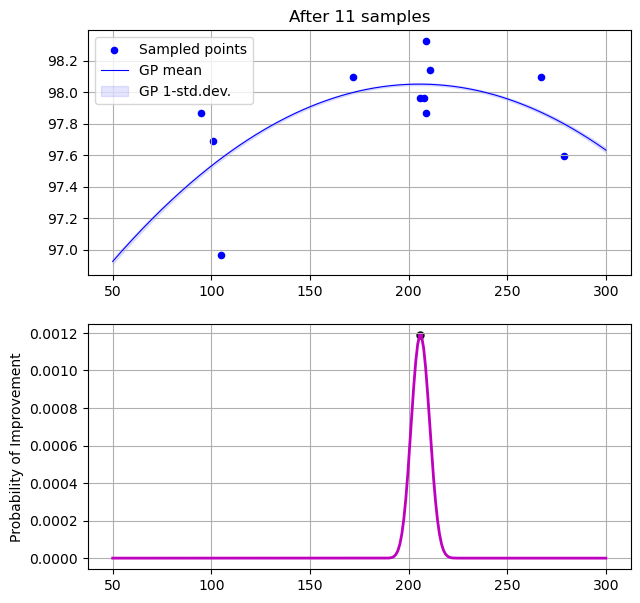

Sample 12: 206


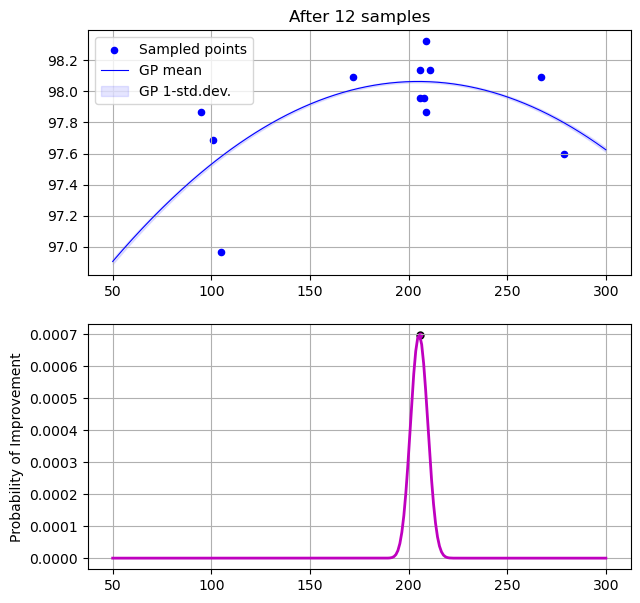

Sample 13: 206


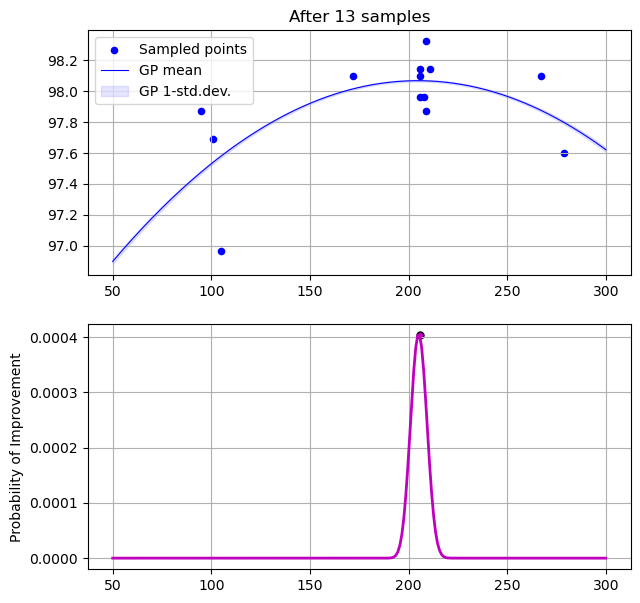

Sample 14: 206


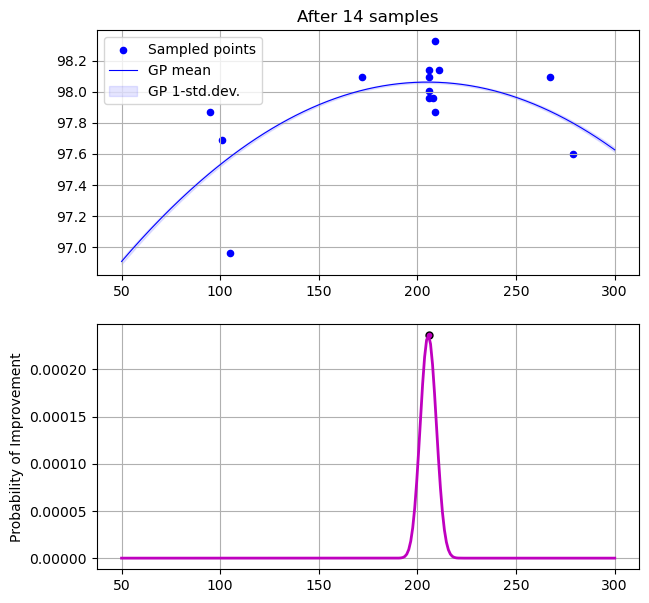

Sample 15: 206


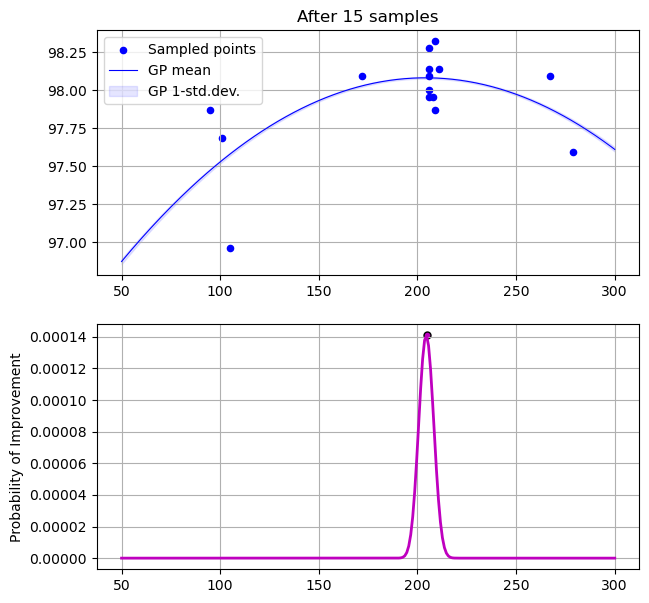

Sample 16: 205


In [195]:
max_iter = 15
for i in range(0, max_iter - initial_samples):
    feat = np.append(feat, round(next_X.item(), 0))
    y_feat = np.append(y_feat, next_Y)
    feat, y_feat = feat.reshape(-1, 1), y_feat.reshape(-1, 1)
    model.fit(feat, y_feat)
    next_X = plot_surrogate_acquisition(model, feat_fine, feat, y_feat, 1)
    next_Y = fcnn(int(round(next_X.item())), 0.001, 50, 10, 10, X_train_part, y_train_part, X_val, y_val)
    plt.show() 
    print(f"Sample {initial_samples+i+2}: {round(next_X.item())}")

### Build optimized neural network

In [196]:
start = time()

# Store optimizied hyperparameters
opt_unit = int(round(next_X.item()))

# Build fully-connected neural network
fcnn_opt = Sequential([Input(shape=(X_train_part.shape[1],)),
    Dense(opt_unit, activation='relu'),
    Dense(int(round(opt_unit/2)), activation='relu'),
    Dense(6, activation='softmax')])

# Early stopping to prevent overtraining
early_stop_fcnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
fcnn_opt.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
fcnn_opt.summary()

# Train the optimize model
history_fcnn_opt = fcnn_opt.fit(X_train_part, y_train_part, epochs=10, batch_size=50, 
                        callbacks=[early_stop_fcnn],
                        validation_data=(X_val, y_val), verbose=1)

print(f"Execution time: {time()-start} sec")

Model: "sequential_254"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_760 (Dense)               │ (None, 205)            │       115,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_761 (Dense)               │ (None, 102)            │        21,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_762 (Dense)               │ (None, 6)              │           618 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,840 (534.53 KB)

 Trainable params: 136,840 (534.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7676 - loss: 0.5996 - val_accuracy: 0.9583 - val_loss: 0.1010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9567 - loss: 0.1121 - val_accuracy: 0.9710 - val_loss: 0.0744
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9817 - loss: 0.0551 - val_accuracy: 0.9728 - val_loss: 0.0607
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9816 - loss: 0.0464 - val_accuracy: 0.9687 - val_loss: 0.0741
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9818 - loss: 0.0477 - val_accuracy: 0.9678 - val_loss: 0.0808
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9859 - loss: 0.0479 - val_accuracy: 0.9728 - val_loss: 0.0758
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9887 - loss: 0.0304 - val_accuracy: 0.9787 - val_loss: 0.0554
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9905 - loss: 0.0254 - val_accuracy: 0.

## Test model

Test Accuracy: 94.20%


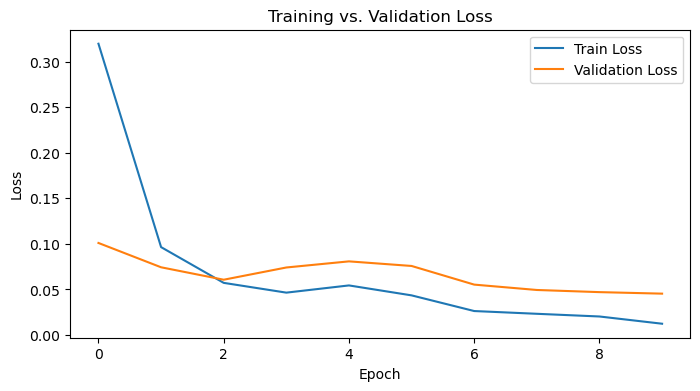

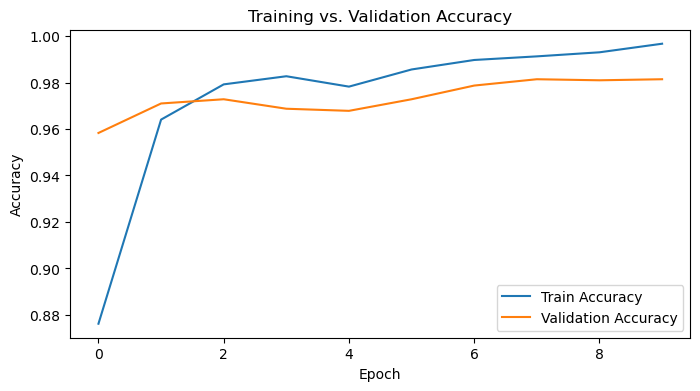

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
y_pred shape: (2947, 6)
y_pred shape: (2947,)


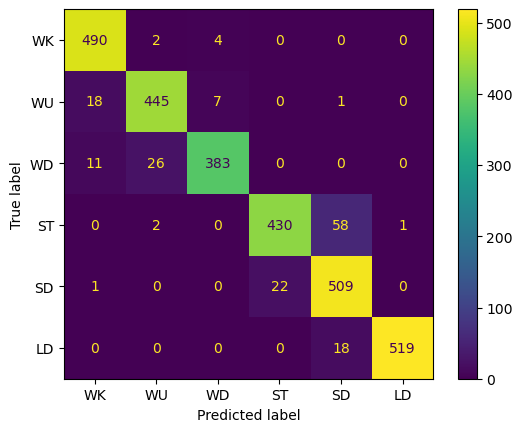

              precision    recall  f1-score   support

          WK       0.94      0.99      0.96       496
          WU       0.94      0.94      0.94       471
          WD       0.97      0.91      0.94       420
          ST       0.95      0.88      0.91       491
          SD       0.87      0.96      0.91       532
          LD       1.00      0.97      0.98       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



In [197]:
# Display test loss and accuracy
test_loss, test_acc = fcnn_opt.evaluate(X_test_scaled, y_test_cat, verbose=0)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

# Display the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_fcnn_opt.history['loss'], label='Train Loss')
plt.plot(history_fcnn_opt.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_fcnn_opt.history['accuracy'], label='Train Accuracy')
plt.plot(history_fcnn_opt.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.show()

# Predict the test set
y_pred = fcnn_opt.predict(X_test_scaled)
print("y_pred shape:", y_pred.shape)
y_pred = he.inverse_transform(y_pred)
y_pred = y_pred.flatten()
print("y_pred shape:", y_pred.shape)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['WK', 'WU', 'WD', 'ST', 'SD', 'LD'])
disp.plot()
plt.show()

# Display the classification report
cr = classification_report(y_test, y_pred, target_names=['WK', 'WU', 'WD', 'ST', 'SD', 'LD'])
print(cr)

# Conclusion

For the purpose of illustration, this exercise only use 10 epochs and the hyperparameter being optimized is the number of units in the fully-connected neural network. Base on this exercise, the optimized hyperparameter value under 15 iterations is 205 with a 94% accuracy.